In [1]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import arviz as az
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.model import functional as F
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from core import DATA_PATH
from models import (
    RectifiedLogistic,
    Logistic5,
    Logistic4,
    ReLU
)

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

NETCODE_FILE = "numpyro_data.nc"
INFERENCE_FILE = "inference.pkl"
BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps"

setup_logging(
    dir=BUILD_DIR,
    fname="comparison"
)


2024-02-01 12:48:46,008 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps/comparison.log


In [2]:
posterior_dirs = [
    ("rats", "/home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps"),
    ("intraoperative", "/home/vishu/repos/hbmep-paper/reports/intraoperative/fn-comparison"),
    ("tms", "/home/vishu/repos/hbmep-paper/reports/tms/fn-comparison")
]

models = [
    ("rectified_logistic", "Rectified Logistic", F.rectified_logistic, [site.a, site.b, site.v, site.L, site.ell, site.H]),
    ("logistic5", "Logistic-5", F.logistic5, [site.a, site.b, site.v, site.L, site.H]),
    ("logistic4", "Logisitc-4", F.logistic4, [site.a, site.b, site.L, site.H]),
    ("relu", "ReLU", F.relu, [site.a, site.b, site.L])
]

In [3]:
model_dict = {}

for dataset, posterior_dir in posterior_dirs:
    model_dict[dataset] = {}

    for model_dir, model_name, _, _ in models:
        src = os.path.join(posterior_dir, model_dir, NETCODE_FILE)
        model_dict[dataset][model_name] = az.from_netcdf(src)


In [4]:
compare_dfs = {}
for dataset, _ in posterior_dirs:
    compare_dfs[dataset] = az.compare(model_dict[dataset]);


/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/vishu/repos/hbmep-paper/.venv/li

In [5]:
rats_models = [RectifiedLogistic, Logistic5, Logistic4, ReLU]

for i, Model in enumerate(rats_models):
    src = os.path.join(posterior_dirs[0][1], Model.NAME, INFERENCE_FILE)
    with open(src, "rb") as g:
        rats_models[i] = pickle.load(g)     # model, mcmc, posterior_samples

base_model = rats_models[0][0]


In [6]:
df = pd.read_csv(DATA_PATH)
df, encoder_dict = base_model.load(df=df)

c = (encoder_dict[base_model.features[0]].transform(["amap05___C5M-C6L"])[0],)
ind = df[base_model.features].apply(tuple, axis=1).isin([c])
df = df[ind].reset_index(drop=True).copy()

n_pulses = 5000
prediction_df = base_model.make_prediction_dataset(df=df, num=n_pulses, min_intensity=0.0, max_intensity=205)


2024-02-01 12:51:17,072 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps/rectified_logistic
2024-02-01 12:51:17,073 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps/rectified_logistic
2024-02-01 12:51:17,083 - hbmep.dataset.core - WARNING - Total non-positive observations: 0
2024-02-01 12:51:17,084 - hbmep.dataset.core - WARNING - Total missing observations: 0
2024-02-01 12:51:17,084 - hbmep.dataset.core - INFO - Processing data ...
2024-02-01 12:51:17,085 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-02-01 12:51:17,099 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec


In [7]:
rats_ppd = []

for model, _, posterior_samples in rats_models:
    rats_ppd.append(model.predict(df=prediction_df, posterior_samples=posterior_samples))


2024-02-01 12:51:24,932 - hbmep.utils.utils - INFO - func:predict took: 7.83 sec
2024-02-01 12:51:32,469 - hbmep.utils.utils - INFO - func:predict took: 7.54 sec
2024-02-01 12:51:39,865 - hbmep.utils.utils - INFO - func:predict took: 7.40 sec
2024-02-01 12:51:47,219 - hbmep.utils.utils - INFO - func:predict took: 7.35 sec


In [8]:
rats_obs_hpdi= [hpdi(ppd[site.obs], prob=.95) for ppd in rats_ppd]


In [9]:
models = [
    ("rectified_logistic", "Rectified Logistic", F.rectified_logistic, [site.a, site.b, site.v, site.L, site.ell, site.H]),
    ("logistic5", "Logistic-5", F.logistic5, [site.a, site.b, site.v, site.L, site.H]),
    ("logistic4", "Logisitc-4", F.logistic4, [site.a, site.b, site.L, site.H]),
    ("relu", "ReLU", F.relu, [site.a, site.b, site.L])
]


In [10]:
pulses = prediction_df[base_model.intensity].unique()

out = [
    [
        fn,
        [rats_models[i][-1][param].mean(axis=0)[c[0], 0] for param in params]
    ]
    for i, (_, _, fn, params) in enumerate(models)
]

out = [
    [
        fn,
        [np.array([param] * n_pulses) for param in params]
    ]
    for fn, params in out
]

out = [fn(pulses, *params) for fn, params in out]


In [11]:
max_color, max_alpha = 255, 100
posterior_color = (204 / max_color, 204 / max_color, 204 / max_color, 15 / max_alpha)
curve_color = (51 / max_color, 51 / max_color, 51 / max_color, 100 / max_alpha)
scatter_color = (179 / max_color, 179 / max_color, 179 / max_color, 100 / max_alpha)
scatter_edgecolor = (255 / max_color, 255 / max_color, 255 / max_color, 100 / max_alpha)


def plot_ppd(ax, i):
    model_name = models[i][1]
    ax.fill_between(
        prediction_df[base_model.intensity],
        rats_obs_hpdi[i][0, :, 0],
        rats_obs_hpdi[i][1, :, 0],
        color=posterior_color
    )
    sns.scatterplot(x=df[base_model.intensity], y=df[base_model.response[0]], color=scatter_color, edgecolor=scatter_edgecolor, ax=ax)
    sns.lineplot(x=prediction_df[base_model.intensity], y=out[i], color=curve_color, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.text(0, 2.2, model_name, fontsize=12)
    return


def plot_compare_df(ax, compare_df):
    az.plot_compare(comp_df=compare_df, ax=ax)
    ax.legend(loc="upper left")
    ax.get_legend().remove()
    ax.set_xlabel("Expected Log-Predictive Density (ELPD)")
    ax.set_ylabel("Ranking (Worst To Best →)")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    return


2024-02-01 12:51:50,948 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps/function_comparison.png


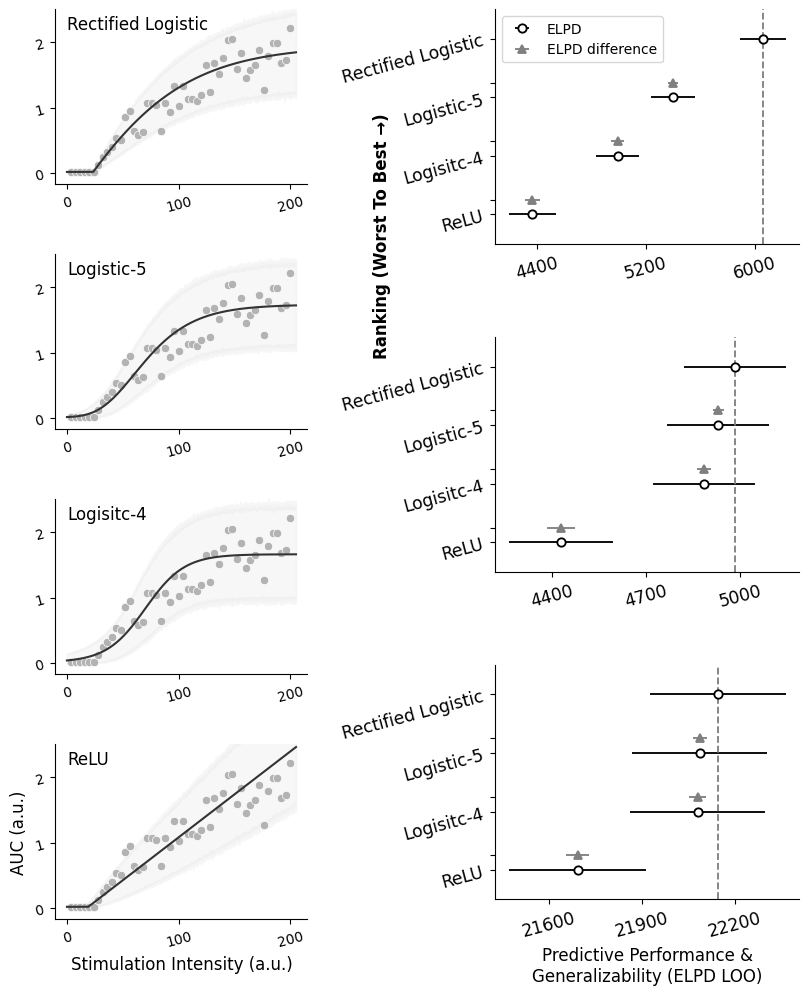

In [12]:
fig = plt.figure(figsize=(8, 10))
subfigs = fig.subfigures(1, 2)

subfig = subfigs.flat[0]
axes = subfig.subplots(4, 1, sharex=True, sharey=True, squeeze=False)

for i, ax in enumerate(axes.flat):
    plot_ppd(ax, i)
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15
    )

ax = axes[0, 0]
ax.set_xticks([0., 100., 200.])
ax.set_yticks([0., 1., 2.])
ax.set_ylim(top=2.5)

ax = axes[-1, 0]
ax.set_ylabel("AUC (a.u.)", fontsize=12)
ax.set_xlabel("Stimulation Intensity (a.u.)", fontsize=12)

subfig.subplots_adjust(left=.12, right=.75, bottom=.07, top=.98, hspace=.4)

subfig = subfigs.flat[1]
axes = subfig.subplots(3, 1, squeeze=False)

for i, ax in enumerate(axes.flat):
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=True,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15
    )
    compare_df = compare_dfs[posterior_dirs[i][0]]
    plot_compare_df(ax, compare_df)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    if i == 0: ax.set_xticks([4400, 5200, 6000])
    if i == 1: ax.set_xticks([4400, 4700, 5000])
    if i == 2: ax.set_xticks([21600, 21900, 22200])
    if not i: ax.legend(loc="upper left")

ax = axes[0, 0]
ax.text(3200, -1.8, "Ranking (Worst To Best →)", fontsize=12, fontweight="bold", rotation=90)


ax = axes[-1, 0]
ax.set_xlabel("Predictive Performance &\nGeneralizability (ELPD LOO)", fontsize=12)

subfig.subplots_adjust(left=.22, right=.98, bottom=.09, top=.98, hspace=.4)

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(BUILD_DIR, "function_comparison.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "function_comparison.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved to {dest}")


2024-02-01 12:54:16,110 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/rats/J_RCML_000/fn-comparison/LBiceps/function_comparison.png


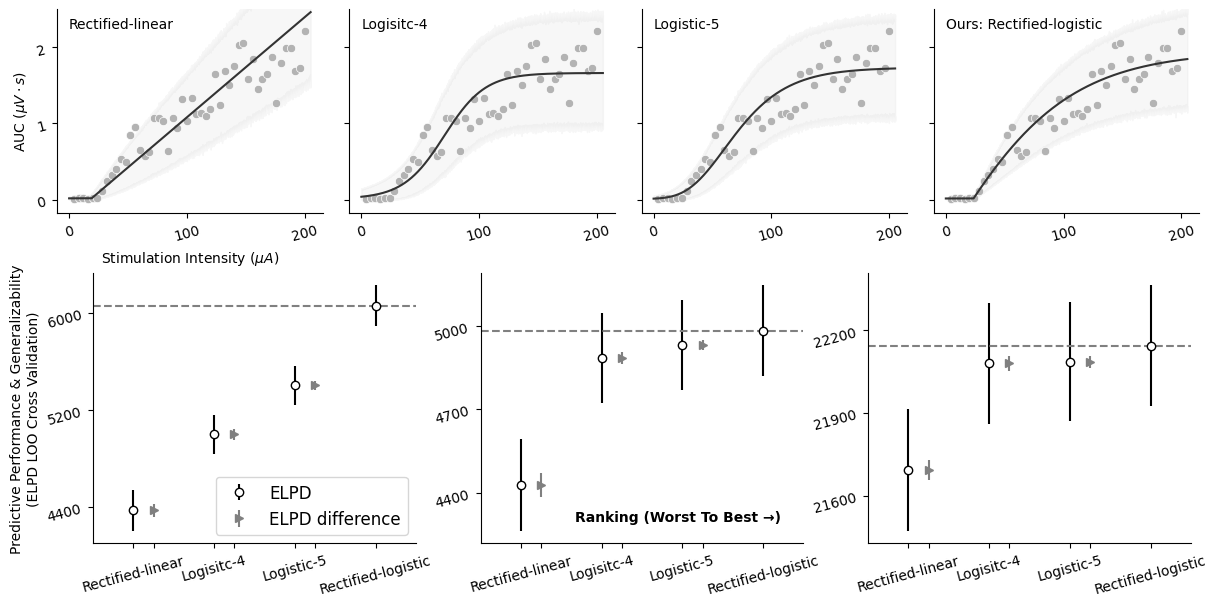

In [15]:
from arviz.labels import BaseLabeller


axis_label_size = 10
axis_label_smaller = 10

max_color, max_alpha = 255, 100
posterior_color = (204 / max_color, 204 / max_color, 204 / max_color, 15 / max_alpha)
curve_color = (51 / max_color, 51 / max_color, 51 / max_color, 100 / max_alpha)
scatter_color = (179 / max_color, 179 / max_color, 179 / max_color, 100 / max_alpha)
scatter_edgecolor = (255 / max_color, 255 / max_color, 255 / max_color, 100 / max_alpha)


def plot_ppd(ax, i):
    model_name = models[i][1]
    ax.fill_between(
        prediction_df[base_model.intensity],
        rats_obs_hpdi[i][0, :, 0],
        rats_obs_hpdi[i][1, :, 0],
        color=posterior_color
    )
    sns.scatterplot(x=df[base_model.intensity], y=df[base_model.response[0]], color=scatter_color, edgecolor=scatter_edgecolor, ax=ax)
    sns.lineplot(x=prediction_df[base_model.intensity], y=out[i], color=curve_color, ax=ax)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    if i == 3: model_name = "Rectified-linear"
    if i == 0: model_name = "Ours: Rectified-logistic"
    ax.text(0., 2.25, model_name, fontsize=axis_label_size)
    return


def plot_compare_df(ax, comp_df):
    # az.plot_compare(comp_df=compare_df, ax=ax)
    yticks_pos, step = np.linspace(0, -1, (comp_df.shape[0] * 2) - 1, retstep=True)
    yticks_pos[1::2] = yticks_pos[1::2] + step / 2

    labeller = BaseLabeller()
    labels = [labeller.model_name_to_str(model_name) for model_name in comp_df.index]

    yticks_labels = [""] * len(yticks_pos)
    yticks_labels[0] = labels[0]
    yticks_labels[2::2] = labels[1:]
    # logger.info(yticks_labels)
    yticks_labels = ['Rectified-logistic', '', 'Logistic-5', '', 'Logisitc-4', '', 'Rectified-linear']

    information_criterion = "elpd_loo"
    column_index = [c.lower() for c in comp_df.columns]
    column_index

    comp_df.sort_values(by="rank", inplace=True)

    ax.errorbar(
        y=comp_df[information_criterion],
        x=yticks_pos[::2],
        yerr=comp_df.se,
        label="ELPD",
        color="k",
        fmt="o",
        mfc="white",
        # mew=linewidth,
        # lw=linewidth,
    )
    ax.errorbar(
        y=comp_df[information_criterion].iloc[1:],
        x=yticks_pos[1::2],
        yerr=comp_df.dse[1:],
        label="ELPD difference",
        color="grey",
        fmt=">",
        # mew=linewidth,
        # elinewidth=linewidth,
    )
    plot_kwargs = {}
    # linewidth =
    ax.axhline(
        comp_df[information_criterion].iloc[0],
        ls=plot_kwargs.get("ls_min_ic", "--"),
        color=plot_kwargs.get("color_ls_min_ic", "grey"),
        # lw=linewidth,
    )
    ax.set_xticks(yticks_pos)
    ax.set_xticklabels(yticks_labels)
    ax.set_xlim(-1 + step, 0 - step)

    ax.legend(loc="upper left")
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    return


fig = plt.figure(figsize=(12, 6))
subfigs = fig.subfigures(2, 1)

subfig = subfigs.flat[0]
axes = subfig.subplots(1, 4, sharex=True, sharey=True, squeeze=False)

for i, ax in enumerate(axes.flat[::-1]):
    plot_ppd(ax, i)
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=axis_label_smaller
    )

ax = axes[0, 0]
ax.set_xticks([0., 100., 200.])
ax.set_yticks([0., 1., 2.])
ax.set_ylim(top=2.5)
ax.tick_params(labelleft=True, labelsize=axis_label_smaller)

ax = axes[0, 0]
ax.set_ylabel("AUC $(\mu V \cdot s)$", fontsize=axis_label_size)
ax.set_xlabel("Stimulation Intensity $(\mu A)$", fontsize=axis_label_size)
subfig.subplots_adjust(left=.04, right=.992, bottom=.3, top=.98, wspace=.1)

subfig = subfigs.flat[1]
axes = subfig.subplots(1, 3, sharex=True, squeeze=False)

for i, ax in enumerate(axes.flat):
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    labelleft = True
    compare_df = compare_dfs[posterior_dirs[i][0]]
    plot_compare_df(ax, compare_df)
    if i > 0: labelleft = True
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=labelleft,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=axis_label_smaller
    )
    # ax.tick_params(axis="x", labelsize=axis_label_size)
    if i == 0: ax.set_yticks([4400, 5200, 6000])
    if i == 1: ax.set_yticks([4400, 4700, 5000])
    if i == 2: ax.set_yticks([21600, 21900, 22200])
    if not i: ax.legend(loc="lower right", fontsize=12)

ax = axes[0, 1]
ax.text(-.35, 4300, "Ranking (Worst To Best →)", fontweight="semibold", fontsize=axis_label_size, rotation=0, ha="center", zorder=5)

ax = axes[0, 0]
ax.set_ylabel("Predictive Performance & Generalizability\n(ELPD LOO Cross Validation)", fontsize=axis_label_size)

subfig.subplots_adjust(left=.07, right=.985, bottom=.2, top=1.1, wspace=.2)

fig.align_xlabels()
fig.align_ylabels()
fig.align_labels()

dest = os.path.join(BUILD_DIR, "function_comparison.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "function_comparison.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved to {dest}")
